In [1]:
# microsoft azure deep learning for time series forecasting
!git clone https://github.com/paulsok/DeepLearningForTimeSeriesForecasting

fatal: destination path 'DeepLearningForTimeSeriesForecasting' already exists and is not an empty directory.


In [2]:
# import necessary packages
import os
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from math import sqrt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

!pip install statsmodels --upgrade
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler

from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

import datetime as dt

%matplotlib inline
warnings.filterwarnings("ignore")

from DeepLearningForTimeSeriesForecasting.common.utils import load_data
from DeepLearningForTimeSeriesForecasting.common.extract_data import extract_data

In [3]:
 # adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [4]:
# download ts_data set
# change the name of the directory with your folder name
!mkdir /content/energy
data_dir = '/content/energy/'

if not os.path.exists(os.path.join(data_dir, 'energy.csv')):
      # download and move the zip file
      !wget https://mlftsfwp.blob.core.windows.net/mlftsfwp/GEFCom2014.zip
      !mv GEFCom2014.zip /content/energy/
      # if not done already, extract zipped data and save as csv
      extract_data(data_dir)

mkdir: cannot create directory ‘/content/energy’: File exists


In [5]:
# load the data from csv into a pandas dataframe
ts_data_load = load_data(data_dir)
ts_data_load.head(10)

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
2012-01-01 05:00:00,"2,453.00",31.33
2012-01-01 06:00:00,"2,560.00",30.00
2012-01-01 07:00:00,"2,719.00",29.00
2012-01-01 08:00:00,"2,916.00",29.00
2012-01-01 09:00:00,"3,105.00",33.33


In [6]:
ts_data_load.index

DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 01:00:00',
               '2012-01-01 02:00:00', '2012-01-01 03:00:00',
               '2012-01-01 04:00:00', '2012-01-01 05:00:00',
               '2012-01-01 06:00:00', '2012-01-01 07:00:00',
               '2012-01-01 08:00:00', '2012-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26304, freq='H')

In [7]:
ts_data_load['2012-1':'2012-2-28'].head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [8]:
# how many null values
ts_data_load.isna().sum()

load    0
temp    0
dtype: int64

In [9]:
# data types
ts_data_load.dtypes

load    float64
temp    float64
dtype: object

In [10]:
# summary statistics
ts_data_load.describe()

,load,temp
count,"26,304.00","26,304.00"
mean,"3,303.77",47.77
std,564.58,19.34
min,"1,979.00",-13.67
25%,"2,867.00",32.67
50%,"3,364.00",48.33
75%,"3,690.00",63.67
max,"5,224.00",95.00


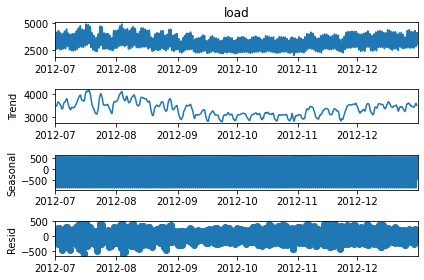

In [11]:
load = ts_data_load.load
decomposition = sm.tsa.seasonal_decompose(load['2012-07-01':'2012-12-31'], model = 'additive')
fig = decomposition.plot()
plt.rcParams['figure.figsize'] = [18.0, 9.0]

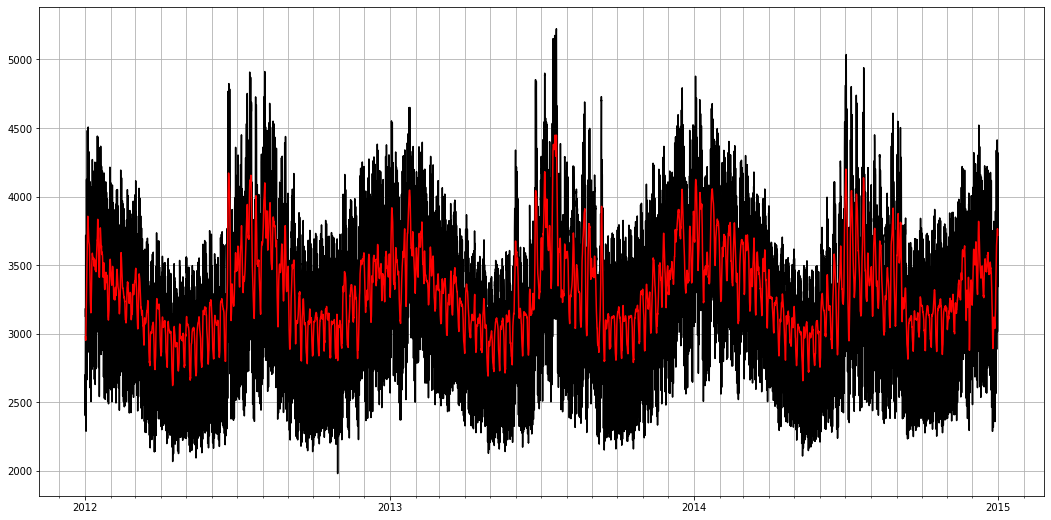

In [12]:
# time series load value and trend decomposition plot
decomposition = sm.tsa.seasonal_decompose(load, model = 'additive')
fig, ax = plt.subplots()
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')

ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

plt.plot(load.index, load, c='black')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')

In [13]:
values = load.values
values = values.reshape((len(values), 1))

# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))

Mean: 3303.769199, StandardDeviation: 564.568521


In [14]:
# datetime features
ts_data_load['hour'] = [ts_data_load.index[i].hour for i in range(len(ts_data_load))]
ts_data_load['month'] = [ts_data_load.index[i].month for i in range(len(ts_data_load))]
ts_data_load['dayofweek'] = [ts_data_load.index[i].day for i in range(len(ts_data_load))]
ts_data_load.head()

,load,temp,hour,month,dayofweek
2012-01-01 00:00:00,"2,698.00",32.00,0,1,1
2012-01-01 01:00:00,"2,558.00",32.67,1,1,1
2012-01-01 02:00:00,"2,444.00",30.00,2,1,1
2012-01-01 03:00:00,"2,402.00",31.00,3,1,1
2012-01-01 04:00:00,"2,403.00",32.00,4,1,1


In [15]:
# create lag features
def generated_lagged_features(ts_data, var, max_lag):
  for t in range(1, max_lag+1):
    ts_data[var+'_lag'+str(t)] = ts_data[var].shift(t, freq='1H')


generated_lagged_features(ts_data_load, 'load', 8)
generated_lagged_features(ts_data_load, 'temp', 8)
ts_data_load.head()

,load,temp,hour,month,dayofweek,load_lag1,load_lag2,load_lag3,load_lag4,load_lag5,load_lag6,load_lag7,load_lag8,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,temp_lag7,temp_lag8
2012-01-01 00:00:00,"2,698.00",32.00,0,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2012-01-01 01:00:00,"2,558.00",32.67,1,1,1,"2,698.00",nan,nan,nan,nan,nan,nan,nan,32.00,nan,nan,nan,nan,nan,nan,nan
2012-01-01 02:00:00,"2,444.00",30.00,2,1,1,"2,558.00","2,698.00",nan,nan,nan,nan,nan,nan,32.67,32.00,nan,nan,nan,nan,nan,nan
2012-01-01 03:00:00,"2,402.00",31.00,3,1,1,"2,444.00","2,558.00","2,698.00",nan,nan,nan,nan,nan,30.00,32.67,32.00,nan,nan,nan,nan,nan
2012-01-01 04:00:00,"2,403.00",32.00,4,1,1,"2,402.00","2,444.00","2,558.00","2,698.00",nan,nan,nan,nan,31.00,30.00,32.67,32.00,nan,nan,nan,nan


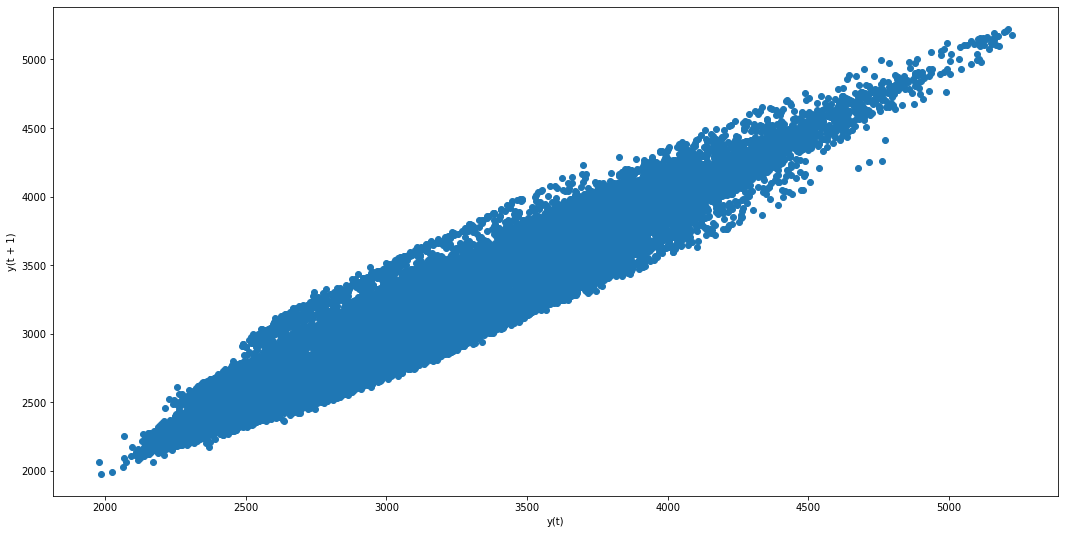

In [16]:
# autocorrelation
lag_plot(load)

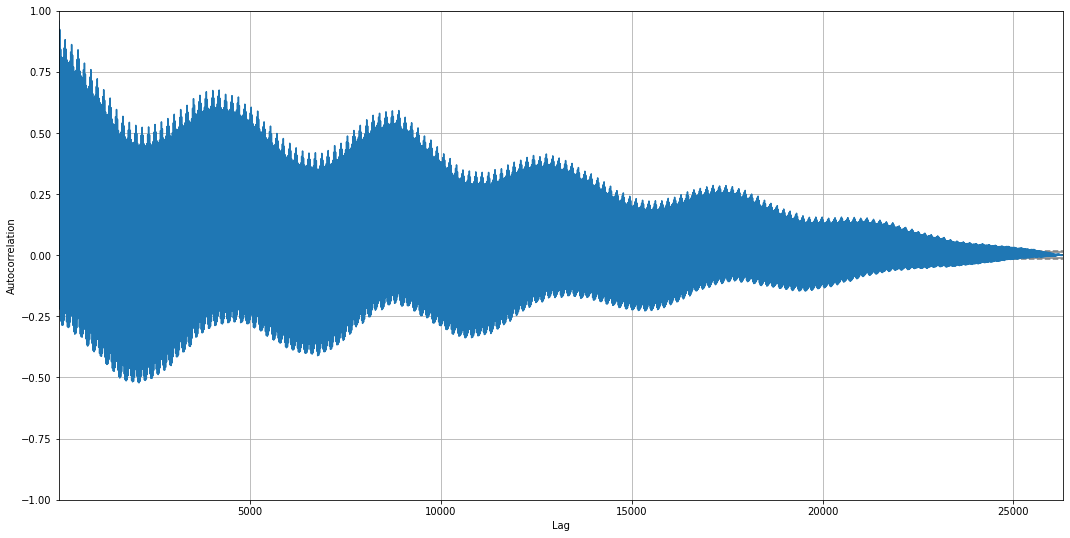

In [17]:
  autocorrelation_plot(load)

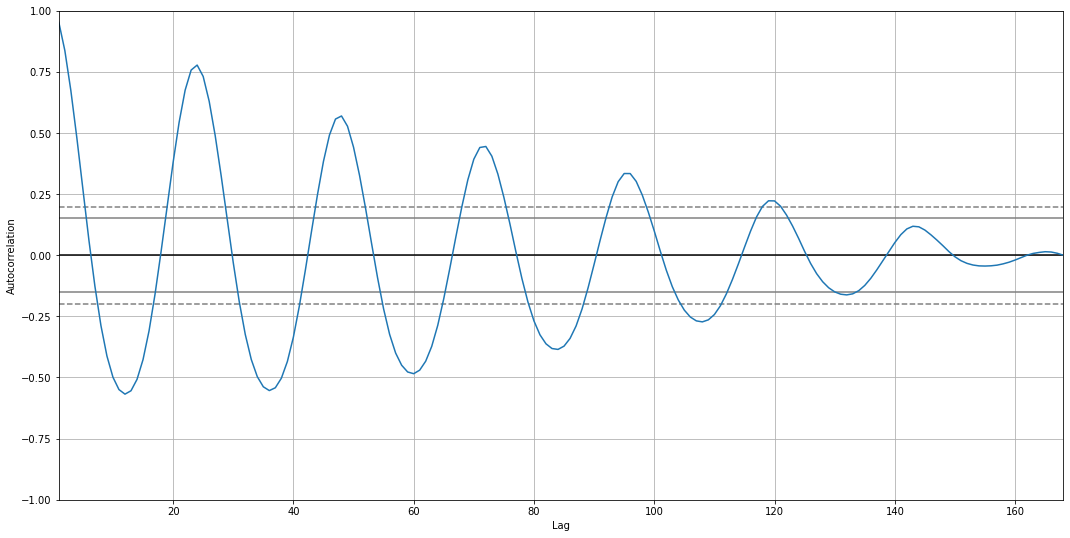

In [18]:
# Create a subset for single plot
ts_data_load_subset = load['2014-08-01':'2014-08-07']
autocorrelation_plot(ts_data_load_subset)

**AutoReg**

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
# Apply AutoReg model
model = AutoReg(load, 1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Sun, 08 Aug 2021   AIC                             10.213
Time:                        20:06:35   BIC                             10.214
Sample:                    01-01-2012   HQIC                            10.214
                         - 12-31-2014                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    144.5181      6.043     23.913      0.000     132.673     156.363
load.L1        0.9563      0.002    530.344      0.000       0.953       0.960
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0457           +0.0000j            1.0457            0.0000
-----------------------------------------------------------------------------
"""

No handles with labels found to put in legend.


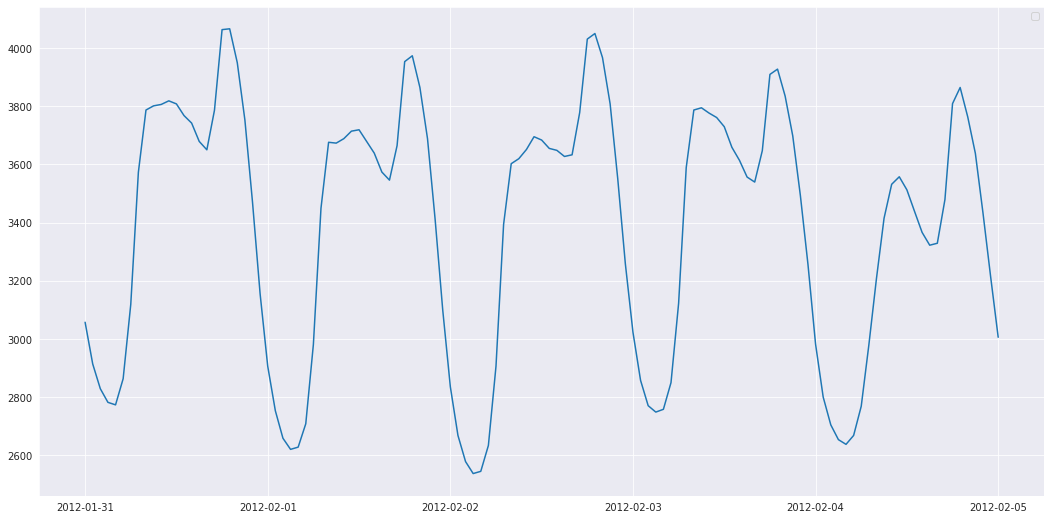

In [20]:
# Define figure style, plot package and default figure size
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()

# Use plot_predict and visualize forecasts
figure = results.plot_predict(720, 840)

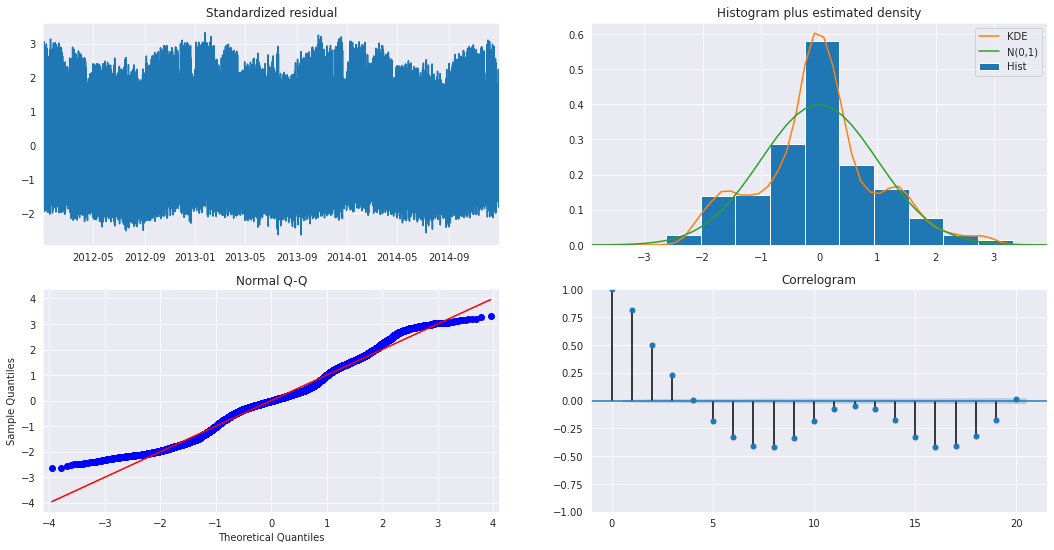

In [21]:
# Use plot_predict and visualize forecasts
fig = plt.figure()
fig = results.plot_diagnostics(fig=fig, lags=20)

**LSTMs and GRUs**

Text(0, 0.5, 'load')

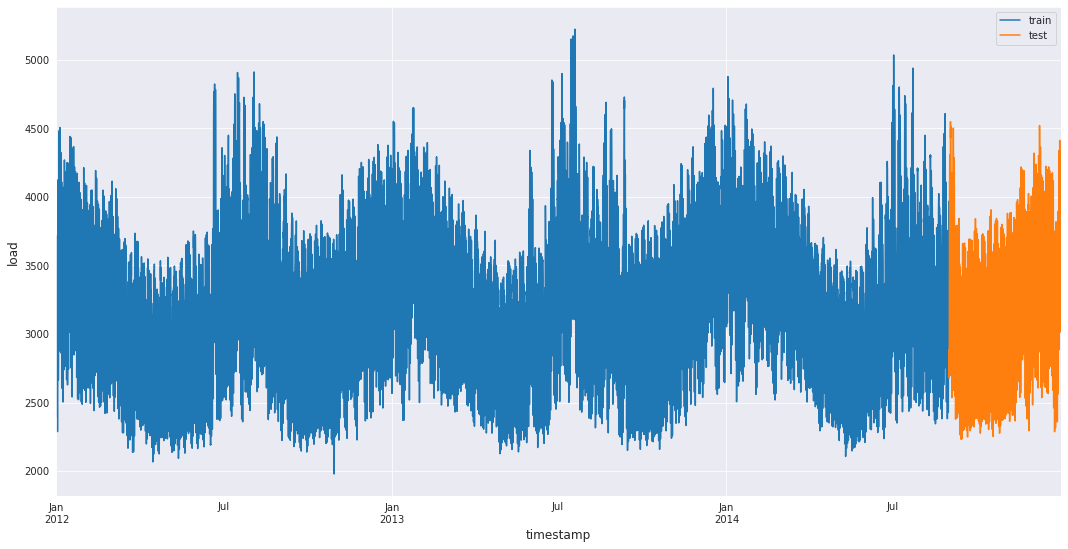

In [22]:
# time periods are available for the train set
test_st_data_load = '2014-09-01 00:00:00'

# Step 1: get the train data from the correct data range
train = ts_data_load[ts_data_load.index < test_st_data_load][['load']]
test = ts_data_load[ts_data_load.index >= test_st_data_load][['load']]

# ts_data_load train, validation, and test data sets plot
df = train.rename(columns={'load':'train'}).join(test.rename(columns={'load':'test'}), how='outer')
df.plot(y=['train', 'test'])
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)

In [23]:
# Step 2: scale data to be in range (0, 1).
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
test['load'] = scaler.fit_transform(test)

In [24]:
# Step 3: shift the dataframe to create the input samples
T = 6 
HORIZON = 1

train_shifted = train.copy()
test_shifted = test.copy()

train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')

for t in range(1, T+1):
  train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
  test_shifted[str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

y_col = 'y_t+1'
X_cols = ['load_t-5', 'load_t-4', 'load_t-3', 'load_t-2', 'load_t-1', 'load_t']

train_shifted.columns = ['load_original']+[y_col]+X_cols
test_shifted.columns = ['load_original']+[y_col]+X_cols

In [25]:
# Step 4: discard missing values
train_shifted = train_shifted.dropna(how='any')
test_shifted = test_shifted.dropna(how='any')
test_shifted.head()

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2014-09-01 05:00:00,0.23,0.28,0.28,0.23,0.20,0.19,0.20,0.23
2014-09-01 06:00:00,0.28,0.36,0.23,0.20,0.19,0.20,0.23,0.28
2014-09-01 07:00:00,0.36,0.51,0.20,0.19,0.20,0.23,0.28,0.36
2014-09-01 08:00:00,0.51,0.64,0.19,0.20,0.23,0.28,0.36,0.51
2014-09-01 09:00:00,0.64,0.73,0.20,0.23,0.28,0.36,0.51,0.64


In [26]:
# Step 5: transform this pandas dataframe into a numpy array
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()
X_test = test_shifted[X_cols].to_numpy()

X_train = X_train.reshape(X_train.shape[0], T, 1)
X_test = X_test.reshape(X_test.shape[0], T, 1)

print(y_train.shape)
print(X_train.shape)
print(X_test.shape)

(23370,)
(23370, 6, 1)
(2922, 6, 1)


In [27]:
# model
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 10

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit
model_history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/10
731/731 [==============================] - 19s 3ms/step - loss: 0.0243
Epoch 2/10
731/731 [==============================] - 2s 3ms/step - loss: 0.0014
Epoch 3/10
731/731 [==============================] - 3s 4ms/step - loss: 8.7064e-04
Epoch 4/10
731/731 [==============================] - 2s 3ms/step - loss: 6.9807e-04
Epoch 5/10
731/731 [==============================] - 2s 3ms/step - loss: 6.0968e-04
Epoch 6/10
731/731 [==============================] - 2s 3ms/step - loss: 5.7204e-04
Epoch 7/10
731/731 [==============================] - 2s 3ms/step - loss: 5.6280e-04
Epoch 8/10
731/731 [==============================] - 2s 3ms/step - loss: 5.6433e-04
Epoch 9/10
731/731 [==============================] - 2s 3ms/step - loss: 5.6147e-04
Epoch 10/10
731/731 [==============================] - 2s 3ms/step - loss: 5.5579e-04


In [30]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.28],
       [0.33],
       [0.44],
       ...,
       [0.64],
       [0.54],
       [0.48]], dtype=float32)